# Importing Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import Callback,EarlyStopping

2022-02-08 20:35:04.732091: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Load Dataset

In [2]:
path = '../input/surface-crack-detection/'
path_all = list(glob.glob(path+'**/*jpg'))
path_Negative = path + 'Negative/*.jpg'
path_Positive = path + 'Positive/*.jpg'

# Visualizing the Dataset

Text(0.5, 1.0, 'Negative and Positive')

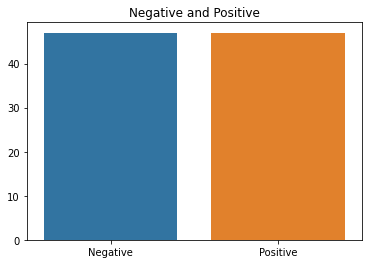

In [3]:
sns.barplot(x=['Negative','Positive'], y=[len(path_Negative), len(path_Positive)])
plt.title('Negative and Positive')

In [4]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_all))
file_Path = pd.Series(path_all, name='File_Path').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([file_Path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Label
0,../input/surface-crack-detection/Negative/1922...,Negative
1,../input/surface-crack-detection/Positive/0780...,Positive
2,../input/surface-crack-detection/Positive/0505...,Positive
3,../input/surface-crack-detection/Positive/0031...,Positive
4,../input/surface-crack-detection/Positive/0327...,Positive


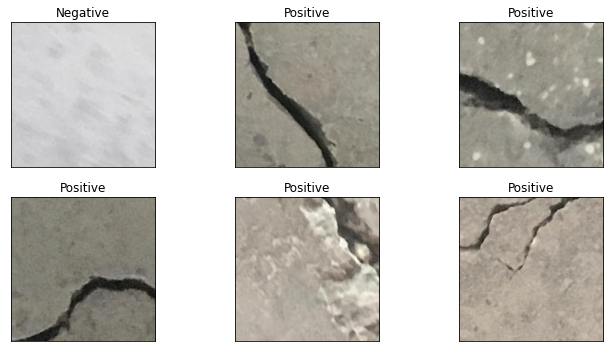

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

# Train & Test Split

In [6]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Functions

In [7]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(
                        preprocessing_function=pre,
                        validation_split=0.2)
    test_datagen = ImageDataGenerator(
                        preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=64,
        subset='training',
        shuffle=True,
        seed=42
        )
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=64,
        subset='validation',
        shuffle=False,
        seed=42
    )
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )
    return train_gen, valid_gen, test_gen

In [8]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input

    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              mode='auto')]
    return model, my_callbacks

In [9]:
def plot(history,df_test,test_gen,train_gen):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(df_test.Label,pred)
    clr = classification_report(df_test.Label, pred, target_names=["NEGATIVE", "POSITIVE"])
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df_test.File_Path.iloc[i+1]))
        ax.set_title(f"True: {df_test.Label.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(6,6))
    sns.heatmap(cm,annot=True,fmt='g',vmin=0,cmap='Blues',cbar=False)
    plt.xticks(ticks=np.arange(2)+.5,labels = ['NEGATIVE','POSITIVE'])
    plt.yticks(ticks=np.arange(2)+.5,labels = ['NEGATIVE','POSITIVE'])
    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.show()
    return history

In [10]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

# CNN with no Transfer Learning

In [11]:
train_data = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True )
test_data = ImageDataGenerator(rescale = 1./255 )
# train_df, test_df
train_data = train_data.flow_from_dataframe( 
        dataframe=train_df,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=64,
        shuffle=False,
        seed=42)
test_data = test_data.flow_from_dataframe( 
        dataframe=test_df,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=64,
        shuffle=False,
        seed=42)

Found 32000 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [12]:
# import keras
# import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout,BatchNormalization 

model = Sequential()
model.add(Conv2D(64,3,padding="same", activation="relu", input_shape = (100,100,3)))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2, activation="softmax"))

model.summary()

2022-02-08 20:35:52.285998: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-08 20:35:52.289173: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-08 20:35:52.330513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 20:35:52.331207: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-02-08 20:35:52.331286: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-02-08 20:35:52.358572: I tensorflow/stream_executor/platform/def

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0

In [13]:
model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              mode='auto')]

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10,
    callbacks=my_callbacks
)

2022-02-08 20:35:54.975102: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-08 20:35:54.979319: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000170000 Hz


Epoch 1/10


2022-02-08 20:35:55.666593: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-02-08 20:35:56.573969: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-02-08 20:35:56.610725: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


500/500 [==============================] - 237s 459ms/step - loss: 0.2252 - accuracy: 0.8850 - val_loss: 0.0312 - val_accuracy: 0.9911
Epoch 2/10
500/500 [==============================] - 128s 254ms/step - loss: 0.0359 - accuracy: 0.9899 - val_loss: 0.0278 - val_accuracy: 0.9914
Epoch 3/10
500/500 [==============================] - 130s 259ms/step - loss: 0.0360 - accuracy: 0.9888 - val_loss: 0.0225 - val_accuracy: 0.9926
Epoch 4/10
500/500 [==============================] - 132s 263ms/step - loss: 0.0212 - accuracy: 0.9935 - val_loss: 0.0298 - val_accuracy: 0.9925


              precision    recall  f1-score   support

    NEGATIVE       0.99      1.00      0.99      3974
    POSITIVE       1.00      0.99      0.99      4026

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000



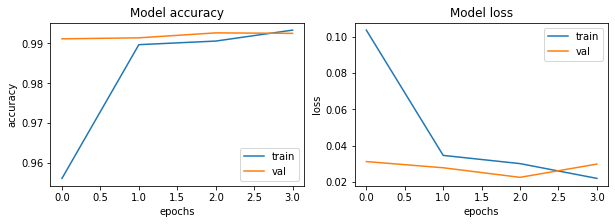

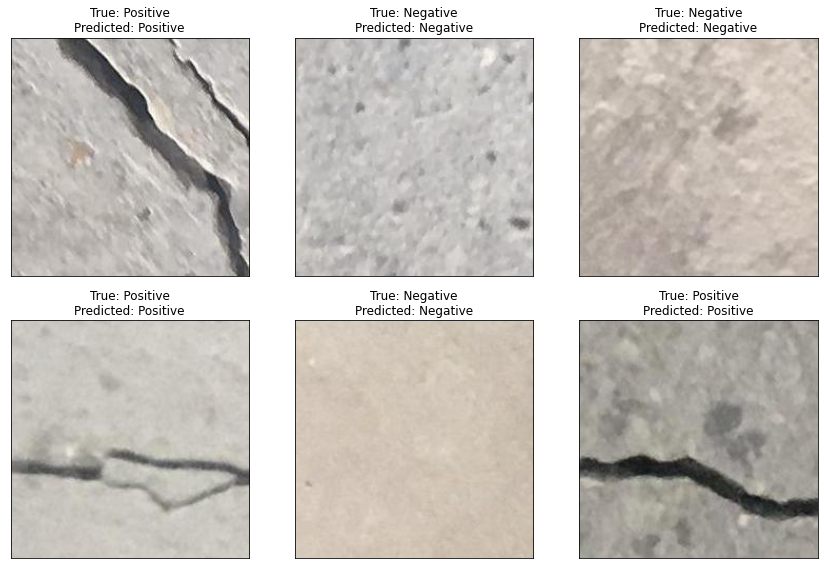

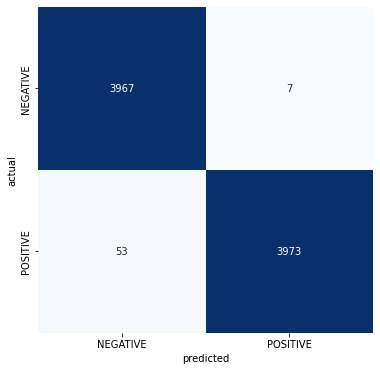

In [14]:
history=plot(history,test_df,test_data,train_data)

In [15]:
result = result_test(test_data,model)

    Test Loss: 0.02982
Test Accuracy: 99.25%


# VGG16

In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg_pre=preprocess_input
train_gen_VGG, valid_gen_VGG, test_gen_VGG = gen(vgg_pre,train_df,test_df)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [17]:
model, callback=func(VGG16)
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
______________________________________________________________

In [18]:
history = model.fit(
    train_gen_VGG,
    validation_data=valid_gen_VGG,
    epochs=10,
    callbacks=callback
)
# batch_size = 128
# history = model.fit_generator(
#     train_gen_VGG,
#     steps_per_epoch = train_gen_VGG.samples // batch_size,
#     validation_data = valid_gen_VGG, 
#     validation_steps = valid_gen_VGG.samples // batch_size,
#     epochs = 10,
#     callbacks=callback)

Epoch 1/10
400/400 [==============================] - 58s 140ms/step - loss: 0.1150 - accuracy: 0.9599 - val_loss: 0.0059 - val_accuracy: 0.9983
Epoch 2/10
400/400 [==============================] - 57s 142ms/step - loss: 0.0092 - accuracy: 0.9976 - val_loss: 0.0079 - val_accuracy: 0.9978


              precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00      3974
    POSITIVE       1.00      1.00      1.00      4026

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



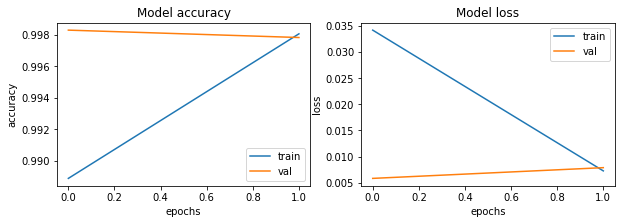

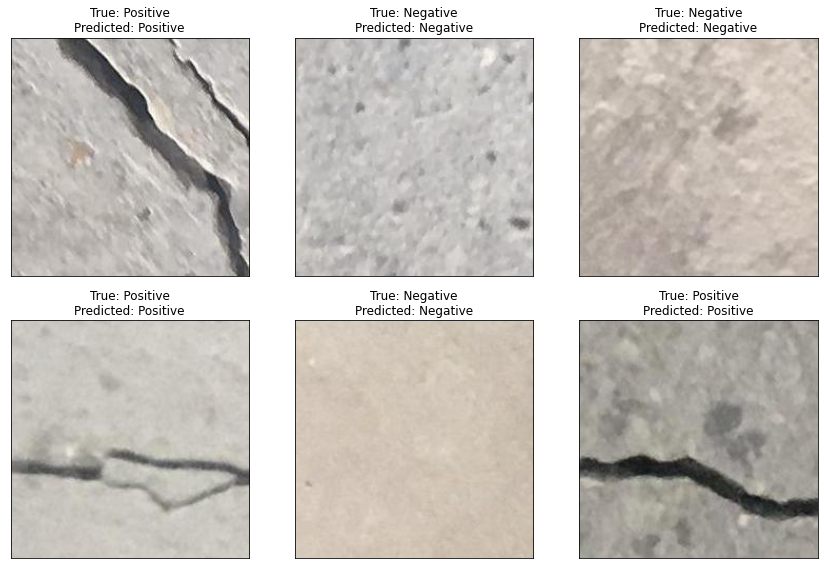

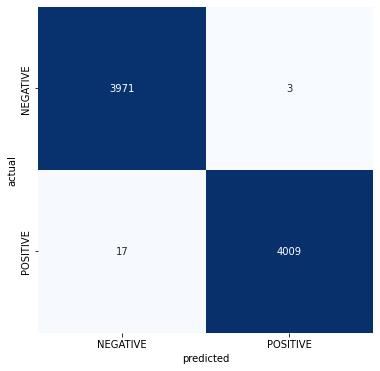

In [19]:
history=plot(history,test_df,test_gen_VGG,train_gen_VGG)

In [20]:
result = result_test(test_gen_VGG,model)

    Test Loss: 0.00749
Test Accuracy: 99.75%


# ResNet50 

In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
RestNet_pre=preprocess_input
train_gen_RestNet, valid_gen_RestNet, test_gen_RestNet = gen(RestNet_pre,train_df,test_df)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [22]:
ResNet50_model, callback=func(ResNet50)

94773248/94765736 [==============================] - 0s 0us/step


In [23]:
history = ResNet50_model.fit(
    train_gen_RestNet,
    validation_data=valid_gen_RestNet,
    epochs=100,
    callbacks=callback
)

Epoch 1/100
400/400 [==============================] - 60s 144ms/step - loss: 0.0568 - accuracy: 0.9774 - val_loss: 0.0045 - val_accuracy: 0.9987
Epoch 2/100
400/400 [==============================] - 58s 144ms/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.0097 - val_accuracy: 0.9973


              precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00      3974
    POSITIVE       1.00      1.00      1.00      4026

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



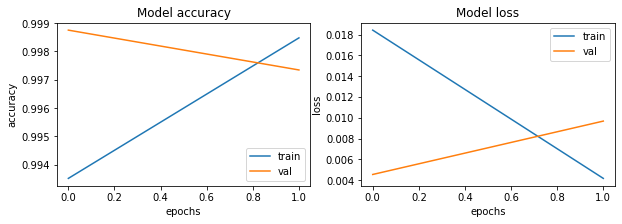

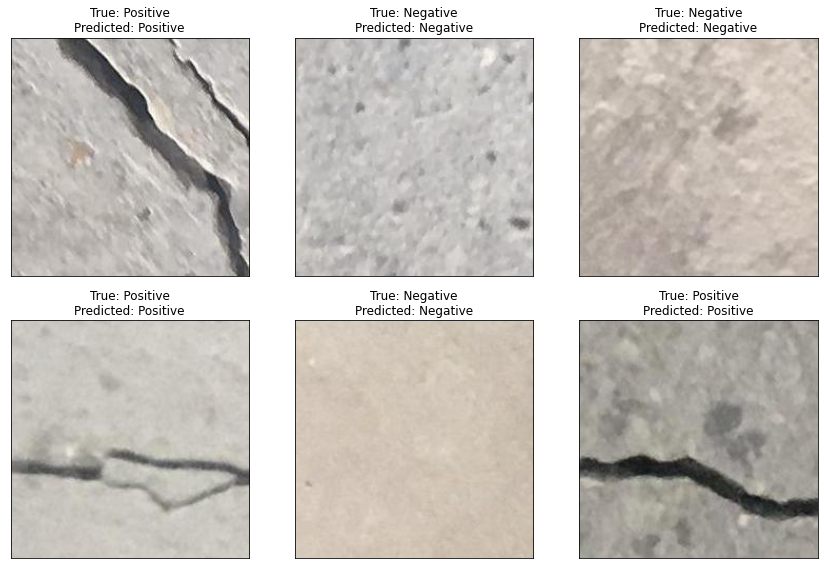

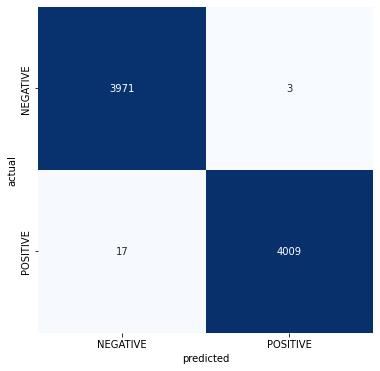

In [24]:
history_ResNet=plot(history,test_df,test_gen_RestNet,train_gen_RestNet)

In [25]:
result_ResNet = result_test(test_gen_RestNet,ResNet50_model)

    Test Loss: 0.01144
Test Accuracy: 99.65%


In [26]:
result_ResNet

[0.011443357914686203, 0.9965000152587891]

# Xception

In [27]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
Xception_pre=preprocess_input
train_gen_Xception, valid_gen_Xception, test_gen_Xception = gen(Xception_pre,train_df,test_df)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [28]:
Xception_model, callback=func(Xception)

83689472/83683744 [==============================] - 0s 0us/step


In [29]:
history = Xception_model.fit(
    train_gen_Xception,
    validation_data=valid_gen_Xception,
    epochs=100,
    callbacks=callback
)

Epoch 1/100
400/400 [==============================] - 57s 136ms/step - loss: 0.1021 - accuracy: 0.9763 - val_loss: 0.0108 - val_accuracy: 0.9969
Epoch 2/100
400/400 [==============================] - 54s 136ms/step - loss: 0.0097 - accuracy: 0.9976 - val_loss: 0.0062 - val_accuracy: 0.9978
Epoch 3/100
400/400 [==============================] - 54s 134ms/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.0089 - val_accuracy: 0.9978


              precision    recall  f1-score   support

    NEGATIVE       0.50      1.00      0.67      3974
    POSITIVE       1.00      0.03      0.05      4026

    accuracy                           0.51      8000
   macro avg       0.75      0.51      0.36      8000
weighted avg       0.75      0.51      0.36      8000



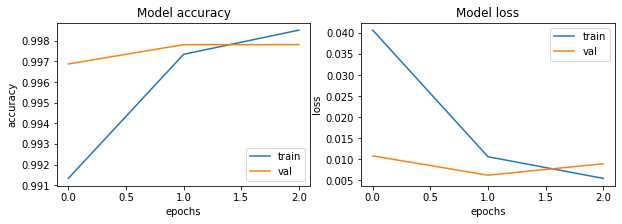

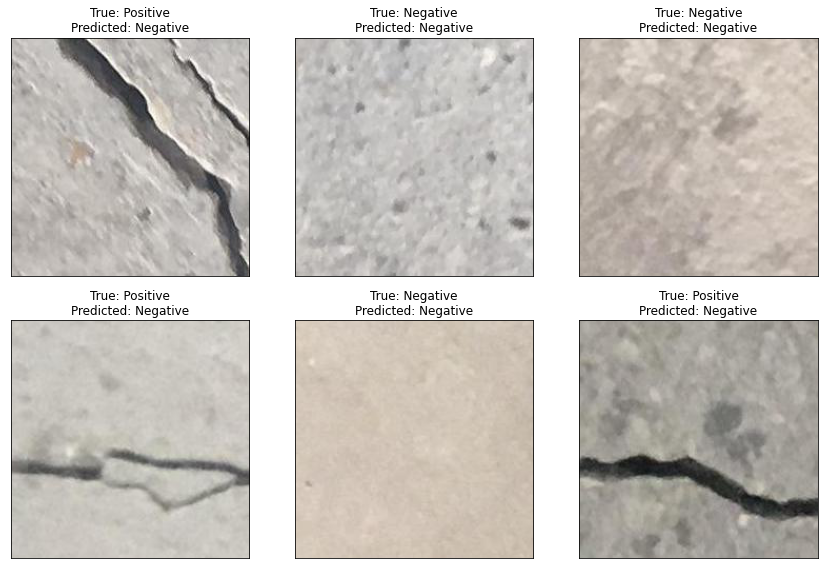

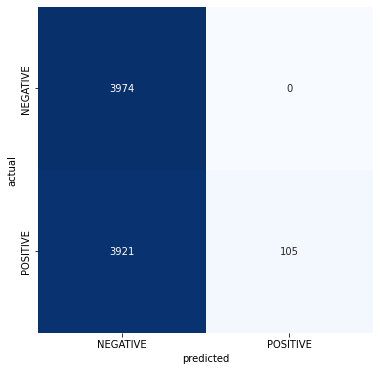

In [30]:
history_Xception=plot(history,test_df,test_gen_Xception,train_gen_Xception)

In [31]:
result_Xception = result_test(test_gen_Xception,Xception_model)

    Test Loss: 0.01014
Test Accuracy: 99.62%


# MobileNet 

In [32]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [33]:
MobileNet_model, callback=func(MobileNet)

17227776/17225924 [==============================] - 0s 0us/step


In [34]:
history_MobileNet = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=100,
    callbacks=callback
)

Epoch 1/100
400/400 [==============================] - 54s 130ms/step - loss: 0.0772 - accuracy: 0.9767 - val_loss: 0.0041 - val_accuracy: 0.9989
Epoch 2/100
400/400 [==============================] - 50s 126ms/step - loss: 0.0034 - accuracy: 0.9987 - val_loss: 0.0043 - val_accuracy: 0.9987


              precision    recall  f1-score   support

    NEGATIVE       0.50      1.00      0.67      3974
    POSITIVE       1.00      0.03      0.05      4026

    accuracy                           0.51      8000
   macro avg       0.75      0.51      0.36      8000
weighted avg       0.75      0.51      0.36      8000



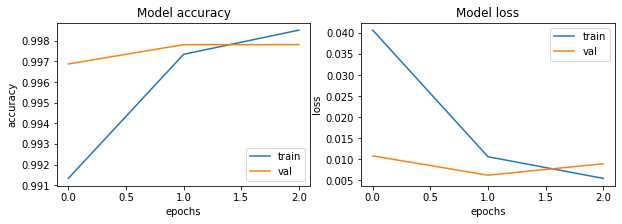

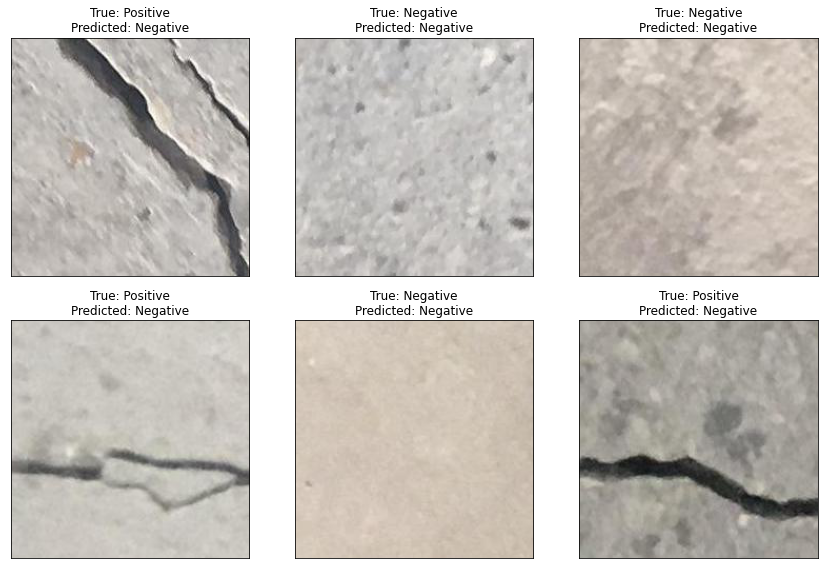

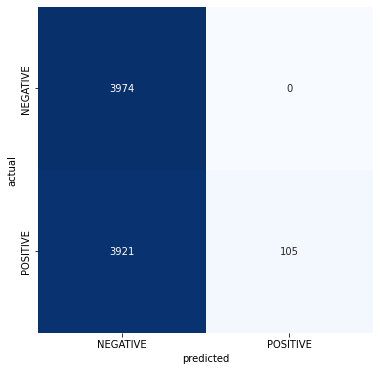

In [35]:
history=plot(history,test_df,test_gen_MobileNet,train_gen_MobileNet)

In [36]:
result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

    Test Loss: 0.00423
Test Accuracy: 99.91%


# Final Report

In [37]:
output = pd.DataFrame({'Model':['VGG16','ResNet50','Xception','MobileNet'],
                      'Accuracy':[result[1], result_ResNet[1], result_Xception[1], result_MobileNet[1]]})

In [38]:
output

,Model,Accuracy
0,VGG16,0.997500
1,ResNet50,0.996500
2,Xception,0.996250
3,MobileNet,0.999125


<AxesSubplot:xlabel='Accuracy', ylabel='Model'>

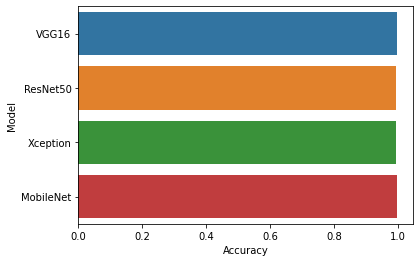

In [39]:
sns.barplot(x='Accuracy', y='Model', data=output)